# Introduction to Vector Databases
Although we have been implementing our own storage for chat history, and the ability to summarize conversations, it would be nice to have a more robust storage solution. It would also be nice to be able to search over our previous conversations.

There are many different options for storing data:
- Redis
- Postgres
- DynamoDB
- Pinecone

But we will use ChromaDB. Everybody has an opinion about various vectorstores, and many of them are valid. The reason we chose ChromaDB is because it is very easy to use, and get up and running quickly.

In this Module, we will first walk through some details of vector databases and then use ChromaDB to store our chat history. This module will lay the fundamental foundations for Retrieval Augmented Generation (RAG).

## What is a Vector Store?
In short, a vector store is a database that store vectors. It is typically considered be part of a broader _**retrieval system**_ that allows you to store and retrieve vectors.

A retrieval system has a few key components and concepts that we will cover in this module:
- **Indexing**: The process of storing vectors in a way that makes them easy to retrieve.
- **Loading**: The process of loading some kind of data, beit existing vectors, PDFs, images, etc.
- **Splitting**: The process of splitting data into smaller chunks, typically for the purpose of creating vectors.
- **Embedding**: The process of converting text data into vectors.
- **Retrieval**: The process of finding similar vectors to a query vector using a _**retriever**_. Also called querying.

<p align="center">
    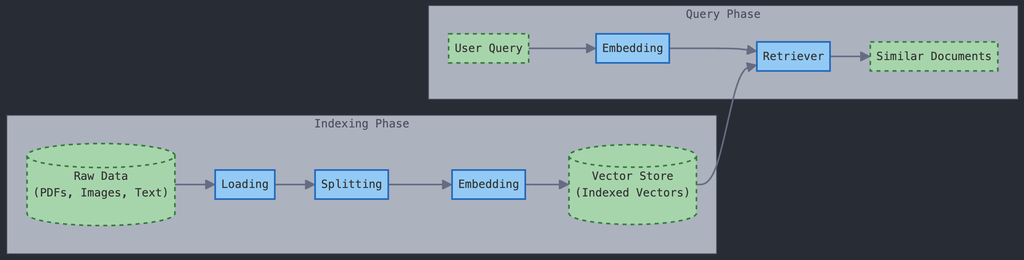
</p>

### Embeddings
We start with embeddings, because they are the reason vector stores even work in the first place! At their core, embedding models are sophisticated tools that transform human language into numerical representations that computers can process efficiently. Think of them as translators that convert the rich, complex meanings in text into precise mathematical coordinates in a high-dimensional space.

When an embedding model processes text - whether it's a short tweet, a technical document, or an entire book - it generates a fixed-length vector (essentially a list of numbers) that captures the semantic essence of that text. For example, a 1536-dimensional embedding means each piece of text is represented by 1,536 carefully calculated numbers. This transformation is remarkable because:

1. Similar meanings cluster together: Documents about "dogs" and "puppies" will have similar vector representations, even if they don't share exact words
2. Relationships are preserved: The vectors for "king" and "queen" might have a similar mathematical relationship as "man" and "woman"
3. Efficient comparison: Computing the similarity between two texts becomes a simple mathematical operation between their vectors

<p align="center">
    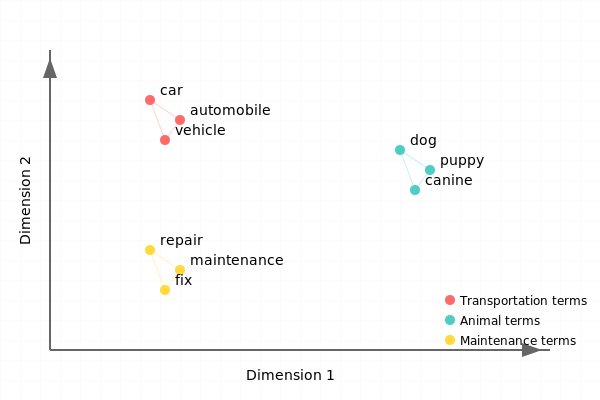
</p>

This mathematical representation enables powerful semantic search capabilities. Unlike traditional keyword matching, which can only find exact word matches, embedding-based search can identify conceptually related content. For instance, a search for "automobile maintenance" might find relevant documents about "car repair" even if those exact words aren't present.

Modern embedding models, trained on vast amounts of text data, have become increasingly sophisticated at capturing nuanced meanings, idiomatic expressions, and even some degree of domain-specific knowledge. This makes them invaluable not just for search, but for a wide range of applications including document classification, content recommendation, and similarity analysis.

Let's look at a concrete example.

In [1]:
import openai
import numpy as np
from numpy.linalg import norm

api_key = "abcd1234"

# We'd also suggest defining the `api_key` attribute from the `openai` module as follows: 
openai.api_key = 'abcd1234'

True

We first call the OpenAI embeddings endpoint in the following way:

In [2]:
def get_embedding(text):
    response = openai.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    return response

def embedding_fn(text):
    response = get_embedding(text)
    return response.data[0].embedding

In [3]:
text1 = "I love playing with my dog"
text2 = "My puppy is my favorite pet"
text3 = "The stock market crashed today"

emb1 = embedding_fn(text1)
emb2 = embedding_fn(text2)
emb3 = embedding_fn(text3)

In theory, `emb1` and `emb2` should be similar, because they are both about dogs, and `emb1` and `emb3` should be dissimilar, because they are about different topics.

We also need a way to compare vectors, so we calculate the cosine similarity between `emb1` and `emb2`, and between `emb1` and `emb3`. The cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. It is calculated as the dot product of the vectors divided by the product of the magnitudes of the vectors, and ranges over $[-1, 1]$:

$$
\cos(\theta) = \frac{A \cdot B}{\|A\| \|B\|}
$$

In [4]:
def cosine_similarity(a, b):
    # Compute cosine similarity between two vectors
    return np.dot(a, b) / (norm(a) * norm(b))

# Compare similarities
sim1_2 = cosine_similarity(emb1, emb2)  # Should be high (dog-related)
sim1_3 = cosine_similarity(emb1, emb3)  # Should be low (unrelated topics)

print(f"Similarity between '{text1}' and '{text2}': {sim1_2:.3f}")
print(f"Similarity between '{text1}' and '{text3}': {sim1_3:.3f}")

Similarity between 'I love playing with my dog' and 'My puppy is my favorite pet': 0.574
Similarity between 'I love playing with my dog' and 'The stock market crashed today': 0.045


A value of $0$ indicates that the vectors are orthogonal to one another, and a value of $-1$ shows that the vectors are diametrically opposed. However this rarely happens in practice, and most of the time the cosine similarity is between $0$ and $1$. In other words, the embedding space is highly anisotropic. This anisotropy will gradually disappear as the dimensionality of the embedding space decreases (either via PCA or by simply taking the first $k$ dimensions of the embedding space).

This anisotropy is most likely caused by a combination of language itself, and the pooling layers in the model.

For more details see [here](https://aclanthology.org/D19-1006.pdf), [here](https://aclanthology.org/2024.naacl-long.274.pdf) and this [random Stack Exchange post](https://datascience.stackexchange.com/questions/101862/cosine-similarity-between-sentence-embeddings-is-always-positive).

So now we should be able to take some text, convert it into a vector, and then compare it to other vectors.

## ChromaDB
We will cover loading and splitting later. For now, we need to actually create a database or index to store these vectors. We will use ChromaDB because it is very easy to use, and has a simple API.

In [5]:
import chromadb
from chromadb.config import Settings

In [6]:
db_client = chromadb.PersistentClient(path="./example_db/", settings=Settings(anonymized_telemetry=False))

You will have noticed that an additional folder has been created:

```bash
.
├── example
│   └── chroma.sqlite3
```

ChromaDB has created a SQLite database for us to store our vectors, and any other information. It is now time to start using it. We need to tell Chroma what model we are using. We can do this two ways, either by embedding text into vectors ourselves, and then feeding them into the database, or by using a Chroma `EmbeddingFunction` to do it for us. Since we have already written code to embed text into vectors, we will use the first method. This gives us more flexibility and separation of concerns.

In [7]:
collection = db_client.get_or_create_collection(
    name="example-collection",
    metadata={
        "description": "Example collection for testing purposes",
        "hnsw:space": "cosine"
    }
)

We can quickly "peek" at the first 10 items of the collection (similar to the Pandas `head` function). We can also get the total number of items in the collection.

In [8]:
collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

In [9]:
collection.count()

0

Obviously, there is nothing in it at the moment!

### Adding content

Let's add our three items to the database.

In [10]:
from datetime import datetime

In [11]:
documents = [text1, text2, text3, "Here is a sentence that I just made up."]
embeddings = [embedding_fn(doc) for doc in documents]

items = {
    "documents": documents,
    "metadatas": [{"date": datetime.now().isoformat()} for _ in documents],
    "embeddings": embeddings,
    "ids": [f"id{i+1}" for i in range(len(documents))]
}


In [12]:
collection.add(**items)

In [13]:
collection.count()

4

Notice that we now have a new folder containing 4 files:

```bash
.
├── example
│   ├── 1aadf7e7-0b7b-4b3b-8b3b-0b7b4b3b8b3b # or something like that
│   │   ├── data_level0.bin
│   │   ├── header.bin
│   │   ├── length.bin
│   │   └── link_lists.bin
│   └── chroma.sqlite3
```

**`data_level0.bin`** contains the actual vectors. `level0` is the "first level" of the database, and is where the actual data is stored

**`header.bin`** contains metadata

**`length.bin`** contains information about the connections between the vectors

**`link_lists.bin`** contains the graph structure of the database obtained using the HNSW algorithm

### Query the database
We now have to query our database and find similar vectors

In [14]:
query = "I like dogs."

query_embedding = embedding_fn(query)

results = collection.query(
    query_embedding,
    n_results=4,
)

In [15]:
results

{'ids': [['id1', 'id2', 'id4', 'id3']],
 'embeddings': None,
 'documents': [['I love playing with my dog',
   'My puppy is my favorite pet',
   'Here is a sentence that I just made up.',
   'The stock market crashed today']],
 'uris': None,
 'data': None,
 'metadatas': [[{'date': '2024-11-14T20:27:04.847466'},
   {'date': '2024-11-14T20:27:04.847486'},
   {'date': '2024-11-14T20:27:04.847490'},
   {'date': '2024-11-14T20:27:04.847488'}]],
 'distances': [[0.41647014236099744,
   0.48467605867776087,
   0.848872312056161,
   0.9433092790643086]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

So the query has returned the "dog"-like sentences as being the top results, and the other two has being fairly dissimilar. This is exactly what we would expect.

Note that when we calculated the cosine similarity, we said that 1 was identical and 0 was orthogonal, whereas here, we are seeing the opposite. This is because ChromaDB is using a distance metric, and so the smaller the number, the closer the vectors are. To get the cosine similarity, we can simply do $1 - distance$.

## The HNSW Algorithm
Now is probably a good time to talk about HNSW or Hierarchical Navigable Small World. HNSW is a top-performing approximate nearest neighbour (ANN) algorithm. Fully understanding HNSW is nontrivial, but we can give a high-level overview.

We can represent our vectors as graphs, where each node is a vector, and each edge is a connection between two vectors. To determine whether two nodes are connected, we can use some distance measure such as Euclidean distance. The issue is: how do we determine this connectivity?

Certain graph structures are easier to traverse than others. One such graph has the "small world" property, which means that most nodes can be reached from every other node by a small number of hops. This is essentially the idea behind 6 degrees of separation. A key hallmark of small world graphs is that they have a high clustering coefficient, and a low average path length, and the number of edges grows logarithmically with the number of nodes.

If we want to be able to search over data efficiently, we should therefore try to replicate this structure. If we have one of these graphs, we can do the following:

1. Pick a target in embedding space
2. Pick an entry point in the graph
3. Determine which of the neighbours of the entry point is closest to the target
4. Move to that neighbour
5. Repeat until we find no closer nodes to the target

This final node is the "local minimum" and is the stopping point.

<p align="center">
    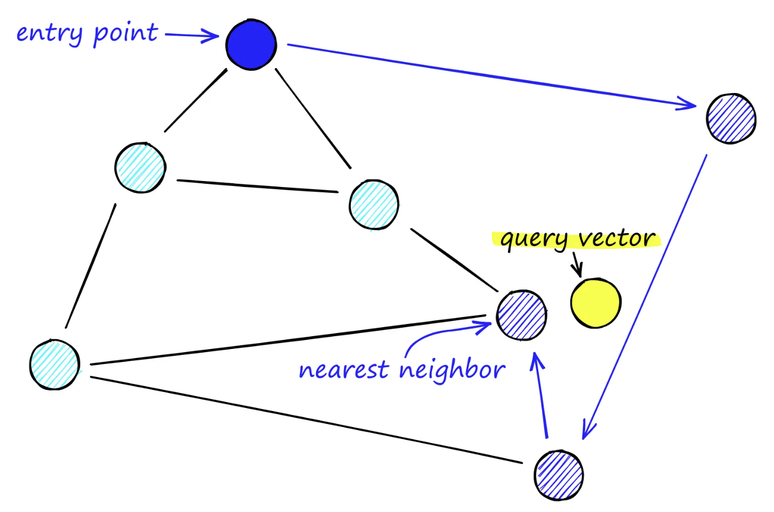
</p>

And where does the hierarchical part come in? We create a graph where links are separated across layers. The top layer is coarse and contains fewer nodes, and the links between then are longer. As we move down through the graph, the links become shorter and more numerous. This allows us to quickly find a "good" starting point, and then refine our search.

<p align="center">
    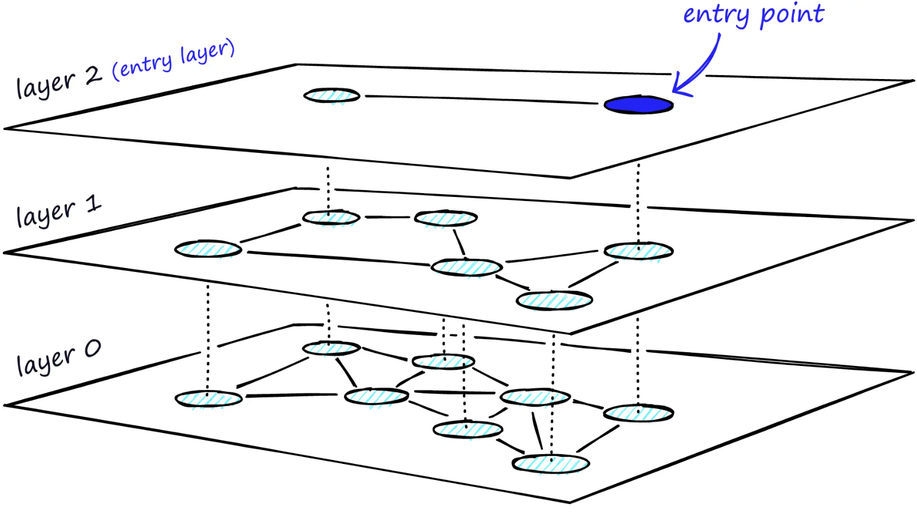
</p>

We enter the graph at the top layer, and then find the nearest neighbour in that layer. We then move down to the next layer, and find the nearest neighbour in that layer. We continue this process until we reach the bottom layer.

During the search process, a priority queue is maintained. This queue contains the nearest neighbours found so far. If a node is found that is closer to the target than the furthest neighbour in the queue, the furthest neighbour is removed, and the new node is added.

Constructing the graph is more involved, and consists of two steps (and maybe a third):

1. **Layer insertions** A new element is inserted into the graph at layer 0. There is then a probability that the element will be inserted into layer 1, and so on.

2. **Connections** In each layer, $M$ nearest neighbours are found using the same search process as above, and connections are made.

3. **Pruning** An optional step that prunes the graph to ensure high quality connections.

To delete items from a collection we can run

In [16]:
collection.delete("id4")

In [17]:
collection.peek()

{'ids': ['id1', 'id2', 'id3'],
 'embeddings': array([[ 0.03069241, -0.04760852,  0.01311912, ..., -0.00705244,
         -0.02312275,  0.02414502],
        [ 0.0439267 , -0.07252212, -0.00894145, ..., -0.00724575,
          0.00035495,  0.01143386],
        [-0.00531931,  0.01150023, -0.00461964, ...,  0.01169577,
          0.00219525,  0.00525515]]),
 'documents': ['I love playing with my dog',
  'My puppy is my favorite pet',
  'The stock market crashed today'],
 'uris': None,
 'data': None,
 'metadatas': [{'date': '2024-11-14T20:27:04.847466'},
  {'date': '2024-11-14T20:27:04.847486'},
  {'date': '2024-11-14T20:27:04.847488'}],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

To delete a collection we can run:

In [18]:
db_client.delete_collection(name="example-collection")

Notice that now all of the graph data has been deleted. You can of course just delete the `example` folder...

## Chat History

In [19]:
import chromadb
import openai

class ChatDB:
    def __init__(self, name: str, model_name: str = "text-embedding-3-small"):
        self.model_name = model_name
        self.client = chromadb.PersistentClient(path="./")

        self.chat_db = self.client.get_or_create_collection(name=name, metadata={"hnsw:space": "cosine"})
        self.id_counter = len(self.chat_db.get()['ids']) if self.chat_db.get()['ids'] else 0

    def get_embedding(self, text: str) -> dict:
        """Get embedding from OpenAI API.
        
        Args:
            text (str): Text to get embedding for.
            
        Returns:
            dict: OpenAI API response containing embedding.
        """
        response = openai.embeddings.create(
            model=self.model_name,  # Use instance model_name
            input=text
        )
        return response

    def embedding_fn(self, text: str) -> list:
        """Extract embedding vector from API response.
        
        Args:
            text (str): Text to get embedding for.
            
        Returns:
            list: Embedding vector.
        """
        response = self.get_embedding(text)
        return response.data[0].embedding

    def add_conversation_to_db(self, user_message: str, ai_message: str) -> None:
        """Add a conversation between user and AI to the database.

        Args:
            user_message (str): User input message.
            ai_message (str): Response from the AI.
        """
        combined = f"User: {user_message}\nAI: {ai_message}"
        embedding = self.embedding_fn(combined)
        self.chat_db.add(
            embeddings=[embedding],
            documents=[combined],
            metadatas=[{"user_message": user_message, "ai_message": ai_message}],
            ids=[str(self.id_counter)]
        )
        self.id_counter += 1

    def get_all_entries(self) -> dict:
        """Grab all of the entries in the database.

        Returns:
            dict: All entries in the database.
        """
        return self.chat_db.get()

    def clear_db(self, reinitialize: bool = True) -> None:
        """Clear the database of all entries, and optionally reinitialize it.

        Args:
            reinitialize (bool): Whether to reinitialize the database after clearing.
                               Defaults to True.
        """
        self.client.delete_collection(self.chat_db.name)
        # re-initialize the database
        if reinitialize:
            self.__init__(self.chat_db.name, self.model_name)

    def query_db(self, query_text: str, n_results: int = 2) -> dict:
        """Query the database for similar entries.

        Args:
            query_text (str): The text to query the database with.
            n_results (int): The number of results to return. Defaults to 2.

        Returns:
            dict: The most similar entries in the database.
        """
        embedding = self.embedding_fn(query_text)
        return self.chat_db.query(
            query_embeddings=[embedding],
            n_results=n_results
        )

In [20]:
chat_db = ChatDB("chat_db", "text-embedding-3-small")

In [21]:
chat_db.add_conversation_to_db(
    "Hello, my name is Alice, how are you?",
    "Nice to meet you Alice, I am Bob. I am fine, thank you for asking. How can I help you today?",
)
chat_db.add_conversation_to_db(
    "I am looking for a restaurant in the area.",
    "Great! What type of cuisine are you in the mood for?",
)

chat_db.add_conversation_to_db(
    "I am looking for some Italian food.",
    "There are many good Italian restaurants in the area. What is your budget?",
)

In [22]:
entries = chat_db.get_all_entries()
for entry in entries["documents"]:
    print(entry)
    print("-"*10)

User: Hello, my name is Alice, how are you?
AI: Nice to meet you Alice, I am Bob. I am fine, thank you for asking. How can I help you today?
----------
User: I am looking for a restaurant in the area.
AI: Great! What type of cuisine are you in the mood for?
----------
User: I am looking for some Italian food.
AI: There are many good Italian restaurants in the area. What is your budget?
----------
User: Hello, my name is Alice, how are you?
AI: Nice to meet you Alice, I am Bob. I am fine, thank you for asking. How can I help you today?
----------
User: I am looking for a restaurant in the area.
AI: Great! What type of cuisine are you in the mood for?
----------
User: I am looking for some Italian food.
AI: There are many good Italian restaurants in the area. What is your budget?
----------


In [23]:
from rich.pretty import pprint

In [24]:
results = chat_db.query_db("I am looking for a restaurant", n_results=3)
pprint(results, expand_all=True)

{
│   'ids': [
│   │   [
│   │   │   '1',
│   │   │   '4',
│   │   │   '2'
│   │   ]
│   ],
│   'embeddings': None,
│   'documents': [
│   │   [
│   │   │   'User: I am looking for a restaurant in the area.\nAI: Great! What type of cuisine are you in the mood for?',
│   │   │   'User: I am looking for a restaurant in the area.\nAI: Great! What type of cuisine are you in the mood for?',
│   │   │   'User: I am looking for some Italian food.\nAI: There are many good Italian restaurants in the area. What is your budget?'
│   │   ]
│   ],
│   'uris': None,
│   'data': None,
│   'metadatas': [
│   │   [
│   │   │   {
│   │   │   │   'ai_message': 'Great! What type of cuisine are you in the mood for?',
│   │   │   │   'user_message': 'I am looking for a restaurant in the area.'
│   │   │   },
│   │   │   {
│   │   │   │   'ai_message': 'Great! What type of cuisine are you in the mood for?',
│   │   │   │   'user_message': 'I am looking for a restaurant in the area.'
│   │   │   },
│   │   │   {
│   │   │   │   'ai_message': 'There are many good Italian restaurants in the area. What is your budget?',
│   │   │   │   'user_message': 'I am looking for some Italian food.'
│   │   │   }
│   │   ]
│   ],
│   'distances': [
│   │   [
│   │   │   0.38922875526506495,
│   │   │   0.38922875526506495,
│   │   │   0.5004012690476796
│   │   ]
│   ],
│   'included': [
│   │   <IncludeEnum.distances: 'distances'>,
│   │   <IncludeEnum.documents: 'documents'>,
│   │   <IncludeEnum.metadatas: 'metadatas'>
│   ]
}

In [25]:
for i, entry in enumerate(results["documents"][0]):
    print(entry)
    print(f"score: {1-results['distances'][0][i]}")
    print("-"*10)

User: I am looking for a restaurant in the area.
AI: Great! What type of cuisine are you in the mood for?
score: 0.610771244734935
----------
User: I am looking for a restaurant in the area.
AI: Great! What type of cuisine are you in the mood for?
score: 0.610771244734935
----------
User: I am looking for some Italian food.
AI: There are many good Italian restaurants in the area. What is your budget?
score: 0.49959873095232044
----------


## Simple booking system
Here we will create a database to store restaurant bookings. We will store the name of the person making the booking, the number of people, the time, and the date. The database is as follows:

In [26]:
import chromadb
from datetime import datetime
import uuid
from typing import Optional, Dict, List
import json

class RestaurantBookingDB:
    def __init__(self, name: str = "restaurant_bookings", model_name: str = "text-embedding-3-small"):
        """Initialize the restaurant booking database.
        
        Args:
            name (str): Name of the ChromaDB collection.
        """
        self.client = chromadb.PersistentClient(path=f"./{name}")
        self.model_name = model_name
        self.collection = self.client.get_or_create_collection(
            name=name,
            metadata={"hnsw:space": "cosine"}
        )

    def get_embedding(self, text: str) -> dict:
        """Get embedding from OpenAI API.
        
        Args:
            text (str): Text to get embedding for.
            
        Returns:
            dict: OpenAI API response containing embedding.
        """
        response = openai.embeddings.create(
            model=self.model_name,  # Use instance model_name
            input=text
        )
        return response

    def embedding_fn(self, text: str) -> list:
        """Extract embedding vector from API response.
        
        Args:
            text (str): Text to get embedding for.
            
        Returns:
            list: Embedding vector.
        """
        response = self.get_embedding(text)
        return response.data[0].embedding

    def generate_booking_id(self) -> str:
        """Generate a unique booking reference ID.
        
        Returns:
            str: A unique 6-character booking reference.
        """
        return str(uuid.uuid4())[:6].upper()

    def add_booking(self, 
                   first_name: str,
                   last_name: str,
                   email: str,
                   phone: str,
                   booking_date: str,  # Format: YYYY-MM-DD
                   booking_time: str,  # Format: HH:MM
                   party_size: int) -> str:
        """Add a new booking to the database.
        
        Args:
            first_name (str): Customer's first name
            last_name (str): Customer's last name
            phone (str): Contact phone number
            booking_date (str): Date of reservation (YYYY-MM-DD)
            booking_time (str): Time of reservation (HH:MM)
            party_size (int): Number of guests
            
        Returns:
            str: The generated booking reference ID
        """
        # Generate unique booking ID
        booking_id = self.generate_booking_id()
        
        # Create timestamp for when booking was made
        booking_created = datetime.now().isoformat()
        
        # Combine all booking details for the searchable document
        document = (
            f"Booking for {first_name} {last_name}, "
            f"party of {party_size} on {booking_date} at {booking_time}. "
            f"Phone: {phone} "
            f"Email: {email}"
        )

        embedding = self.embedding_fn(document)
        
        # Create metadata with all individual fields
        metadata = {
            "first_name": first_name,
            "last_name": last_name,
            "email": email,
            "phone": phone,
            "booking_date": booking_date,
            "booking_time": booking_time,
            "party_size": party_size,
            "booking_created": booking_created,
            "booking_id": booking_id
        }
        
        # Store in ChromaDB
        self.collection.add(
            embeddings=[embedding],
            documents=[document],
            metadatas=[metadata],
            ids=[booking_id]
        )
        
        return booking_id

    def get_booking_by_id(self, booking_id: str) -> Optional[Dict]:
        """Retrieve a booking using its reference ID.
        
        Args:
            booking_id (str): The booking reference ID
            
        Returns:
            Optional[Dict]: Booking details if found, None otherwise
        """
        try:
            result = self.collection.get(
                ids=[booking_id],
                include=['metadatas', 'documents']
            )
            if result['ids']:
                return {
                    **result['metadatas'][0],
                    'full_details': result['documents'][0]
                }
            return None
        except Exception:
            return None

    def search_bookings(self, 
                       query: str,
                       n_results: int = 5,
                       date_filter: Optional[str] = None) -> List[Dict]:
        """Search bookings using natural language query.
        
        Args:
            query (str): Search query (e.g., "Smith party of 4")
            n_results (int): Maximum number of results to return
            date_filter (Optional[str]): Filter by specific date (YYYY-MM-DD)
            
        Returns:
            List[Dict]: List of matching bookings
        """
        # If date filter is provided, create where clause
        where = {"booking_date": date_filter} if date_filter else None

        query_embedding = self.embedding_fn(query)
        
        results = self.collection.query(
            query_embeddings=[query_embedding],
            n_results=n_results,
            where=where,
            include=['metadatas', 'documents']
        )
        
        return [
            {**meta, 'full_details': doc}
            for meta, doc in zip(results['metadatas'][0], results['documents'][0])
        ]

    def update_booking(self,
                      booking_id: str,
                      **updates) -> bool:
        """Update an existing booking.
        
        Args:
            booking_id (str): Booking reference ID
            **updates: Fields to update (first_name, last_name, etc.)
            
        Returns:
            bool: True if successful, False otherwise
        """
        try:
            # Get existing booking
            current = self.get_booking_by_id(booking_id)
            if not current:
                return False
            
            # Update the specified fields
            metadata = {**current}
            metadata.update(updates)
            
            # Create new document text
            document = (
                f"Booking for {metadata['first_name']} {metadata['last_name']}, "
                f"party of {metadata['party_size']} on {metadata['booking_date']} "
                f"at {metadata['booking_time']}. Phone: {metadata['phone']} "
                f"Email: {metadata['email']}"
            )

            embedding = self.embedding_fn(document)
            
            # Update in ChromaDB
            self.collection.update(
                embeddings=[embedding],
                ids=[booking_id],
                metadatas=[metadata],
                documents=[document]
            )
            
            return True
        except Exception:
            return False

    def delete_booking(self, booking_id: str) -> bool:
        """Delete a booking from the database.
        
        Args:
            booking_id (str): Booking reference ID
            
        Returns:
            bool: True if successful, False otherwise
        """
        try:
            self.collection.delete(ids=[booking_id])
            return True
        except Exception:
            return False

    def get_bookings_for_date(self, date: str) -> List[Dict]:
        """Get all bookings for a specific date.
        
        Args:
            date (str): Date in YYYY-MM-DD format
            
        Returns:
            List[Dict]: List of bookings for the specified date
        """
        results = self.collection.get(
            where={"booking_date": date},
            include=['metadatas', 'documents']
        )
        
        return [
            {**meta, 'full_details': doc}
            for meta, doc in zip(results['metadatas'], results['documents'])
        ]

We create the database and add a few bookings:

In [27]:
# Create the database
db = RestaurantBookingDB()

# Add a new booking
booking_id = db.add_booking(
    first_name="John",
    last_name="Smith",
    email="jsmith@email.com",
    phone="555-0123",
    booking_date="2024-11-15",
    booking_time="19:30",
    party_size=4
)
print(f"Booking reference: {booking_id}")

# Retrieve booking by ID
booking = db.get_booking_by_id(booking_id)

# Search for bookings
results = db.search_bookings("Smith party of 4")

# Get all bookings for a date
date_bookings = db.get_bookings_for_date("2024-11-15")

# Update a booking
db.update_booking(booking_id, party_size=6)

# Delete a booking
db.delete_booking(booking_id)

Booking reference: 462D31


Number of requested results 5 is greater than number of elements in index 1, updating n_results = 1


True

In [28]:
db.collection.peek()

{'ids': [],
 'embeddings': array([], dtype=float64),
 'documents': [],
 'uris': None,
 'data': None,
 'metadatas': [],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

Now let's add a bunch of bookings:

In [29]:
from pydantic import BaseModel, Field

In [30]:
from pydantic import BaseModel, Field

class CustomerBooking(BaseModel):
    first_name: str = Field("unknown")
    last_name: str = Field("unknown")
    email: str = Field("unknown")
    phone: str = Field("unknown")
    booking_date: str = Field(None, description="Date of reservation (YYYY-MM-DD)")
    booking_time: str = Field(None, description="Time of reservation (HH:MM) in 24-hour format")
    party_size: int = Field(None, gt=0, le=20)

In [31]:
schema = CustomerBooking().model_json_schema()

In [32]:
json.dumps(schema)

'{"properties": {"first_name": {"default": "unknown", "title": "First Name", "type": "string"}, "last_name": {"default": "unknown", "title": "Last Name", "type": "string"}, "email": {"default": "unknown", "title": "Email", "type": "string"}, "phone": {"default": "unknown", "title": "Phone", "type": "string"}, "booking_date": {"default": null, "description": "Date of reservation (YYYY-MM-DD)", "title": "Booking Date", "type": "string"}, "booking_time": {"default": null, "description": "Time of reservation (HH:MM) in 24-hour format", "title": "Booking Time", "type": "string"}, "party_size": {"default": null, "exclusiveMinimum": 0, "maximum": 20, "title": "Party Size", "type": "integer"}}, "title": "CustomerBooking", "type": "object"}'

In [33]:
from utils import TemplateManager
from openai import OpenAI

True

Our template is:

---
```jinja
Generate a random customer booking for a restaurant.
Here is the json schema for the booking:

{{ schema }}

You will be given a first and last name:

first name: {{ first_name }}
last name: {{ last_name }}

Fill in all detail for the booking, including the given name.

Give the person in JSON format.
```
---

In [34]:
template_manager = TemplateManager("./prompts")

In [39]:
# If you haven't set the .api_key attribute previously, then you'll need to pass in `api_key` as an argument here:
client = OpenAI(api_key = api_key)

def generate_person(first_name, last_name, **kwargs) -> str:
    prompt = template_manager.render(
        'name_gen.jinja',
        schema=CustomerBooking().model_json_schema(),
        first_name=first_name,
        last_name=last_name,
        force_reload=True,
    )
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages = [
            {"role": "user", "content": prompt},
        ],
        **kwargs
    )

    return response

In [40]:
first_names = [
    "Emma", "Liam", "Olivia", "Noah", "Ava", "Oliver", "Isabella", "William",
    "Sophia", "James"
]

last_names = [
    "Smith", "Johnson", "Williams", "Brown", "Jones", "Garcia", "Miller",
    "Davis", "Rodriguez", "Martinez"
]

In [41]:
people = []
for first_name, last_name in zip(first_names, last_names):
    person = generate_person(first_name, last_name, response_format={ "type": "json_object" }, temperature=0.7)
    try:
        person = CustomerBooking(**json.loads(person.choices[0].message.content))
        people.append(person)
        
    except Exception as e:
        print("Failed to parse person: {first_name} {last_name}")

In [44]:
ids = []
for person in people:
    ids.append(db.add_booking(**person.dict()))

Now we can query the database in a number of ways.

In [59]:
import openai
from datetime import datetime
from typing import Tuple, List, Dict

class BookingAssistant:
    def __init__(self):
        self.chat_history = []  # List to store conversation history
        self.system_prompt = template_manager.render("booking_system.jinja")
        self.booking_db = RestaurantBookingDB("restaurant_bookings")
        
    def _generate_response(self, user_message: str, context: str) -> str:

        messages = [{"role": "system", "content": self.system_prompt}]
        
        # Add chat history
        messages.extend(self.chat_history)
        
        # Add current context and query
        messages.append({
            "role": "user",
            "content": f"Context from database: {context}\n\nUser query: {user_message}"
        })
        
        response = openai.chat.completions.create(
            model="gpt-4o-mini",
            messages=messages,
            temperature=0.7,
            max_tokens=150
        )
        
        # Get the response content
        assistant_response = response.choices[0].message.content
        
        # Add the current exchange to chat history
        self.chat_history.append({"role": "user", "content": user_message})
        self.chat_history.append({"role": "assistant", "content": assistant_response})
        
        return assistant_response

    def _search_bookings(self, query: str) -> Tuple[str, list]:
        """Search bookings and format results for context."""
        results = self.booking_db.search_bookings(query, n_results=3)
        if not results:
            return "No bookings found matching your query.", []
        
        context = "\n".join([result['full_details'] for result in results])
        return context, results

    def chat_loop(self):
        """Interactive chat loop for booking queries."""
        print("Welcome to the Restaurant Booking Assistant! (Type 'quit' to exit)")
        print("You can ask about your booking or provide your booking reference.")
        
        while True:
            user_input = input("\nYou: ").strip()
            
            if user_input.lower() in ['quit', 'exit', 'bye']:
                print("Thank you for using the Booking Assistant. Goodbye!")
                break
            
            # Search for relevant bookings
            context, results = self._search_bookings(user_input)
            
            # Generate AI response
            ai_response = self._generate_response(user_input, context)
            
            print(f"\nAssistant: {ai_response}")

In [60]:

assistant = BookingAssistant()
assistant.chat_loop()


Welcome to the Restaurant Booking Assistant! (Type 'quit' to exit)
You can ask about your booking or provide your booking reference.

Assistant: Could you please provide your name or booking reference number so I can look up your booking details?

Assistant: Your booking is for November 15, 2023, at 19:30 for a party of 4. If you need any further assistance, feel free to ask!

Assistant: Could you please provide your father's name or booking reference number so I can look up his booking details?

Assistant: Your father's booking is for October 15, 2023, at 19:30 for a party of 4. If you need any more information, just let me know!

Assistant: Your booking is for November 15, 2023, at 19:30 for a party of 4. If you have any more questions, feel free to ask!

Assistant: Your name is Isabella Miller. If you need any more information, just let me know!

Assistant: Your father's name is Liam Johnson. If you need any further assistance, feel free to ask!

Assistant: Your name is Emma Smith. 

So this in general is quite bad, there are a few things we can do to improve this.